<a href="https://colab.research.google.com/github/drlcai/kaggle/blob/main/js2024_kaggle_vae_mlp_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os

In [ ]:
os.getcwd()

'/content/drive/MyDrive/kaggle/js_2024'

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!echo '{"username":"lerancai","key":"ca78a2204d5d39882b66b2584e7df24f"}' > ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle dataset list

usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: argument command: invalid choice: 'dataset' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'models', 'm', 'files', 'f', 'config')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/kaggle/js_2024"

/content/drive/MyDrive/kaggle/js_2024


In [ ]:
!kaggle competitions download -c jane-street-real-time-market-data-forecasting

100% 11.4G/11.5G [01:24<00:00, 85.4MB/s]
100% 11.5G/11.5G [01:24<00:00, 146MB/s] 


In [ ]:
!unzip -q jane-street-real-time-market-data-forecasting.zip

In [ ]:
!rm -f jane-street-real-time-market-data-forecasting.zip

In [ ]:
!mkdir -p research_data

# Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/kaggle/js_2024"

/content/drive/MyDrive/kaggle/js_2024


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, List
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import minimize

import gc
import sys
import time
import pyarrow.feather as feather
import pickle


In [4]:
feature_cols = [f"feature_{i:02d}" for i in range(79)]
target_col = "target"
responder_cols = ["responder_0", "responder_1", "responder_2", "responder_3", "responder_4", "responder_5", "responder_7", "responder_8"]

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def correlation_plot(df, feature_set, show_annot=False, fig_size=(10,10), ft_size=5):
    cluster_map = sns.clustermap(
        df.dropna(subset=feature_set)[feature_set].corr(),
        vmin=-1,
        vmax=1,
        cmap="bwr",
        figsize=fig_size,
        annot=show_annot,
        annot_kws={"size":ft_size},
        fmt=".2f"
    )
    plt.show()
    return cluster_map

def preprocess_dataframe(df_in):
    df = df_in.copy()
    df = reduce_mem_usage(df)
    df.rename(columns={
        'responder_6':'target',
    }, inplace=True)

    return df[["date_id", "time_id", "symbol_id", "weight"]
              + feature_cols
              + [target_col]
              + responder_cols]

def clip_feature(series, c=0.01):
    lower = series.quantile(c)
    upper = series.quantile(1-c)
    return np.clip(series, lower, upper)

def weighted_MSE(df, x, y):
    ans = ((df[y].fillna(0) - df[x].fillna(0)) ** 2 * df["weight"].fillna(0)).sum()
    return ans

def weighted_Rsquared(df, x, y):
    return 1 - weighted_MSE(df, x, y) / (df[y].fillna(0)**2 * df["weight"].fillna(0)).sum()

# Save data

In [ ]:
%%time
# for i in range(10):
#     df_tmp = pd.read_parquet(f'./train.parquet/partition_id={i}/part-0.parquet')
#     print(f"Reading: ./train.parquet/partition_id={i}/part-0.parquet")
#     # rename, shrink, or some more clever stuff to be added later
#     df_tmp = preprocess_dataframe(df_tmp)

#     feather.write_feather(
#         df_tmp,
#         f"./research_data/research_data_part_{i}.feather.zstd",
#         compression="zstd"
#     )

#     del df_tmp
#     gc.collect()

# df_research_train = pd.DataFrame()
# for i in range(10):
#     print(f"Reading research_data_part_{i}.feather.zstd")
#     df_tmp = pd.read_feather(f"./research_data/research_data_part_{i}.feather.zstd")
#     df_research_train = pd.concat([df_research_train, df_tmp])
#     del df_tmp
#     gc.collect()

# df_research_train.reset_index(drop=True, inplace=True)
# print(df_research_train.duplicated(["date_id", "time_id", "symbol_id"]).sum())


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [ ]:
feather.write_feather(df_research_train, f"./research_data/research_data_train.feather.zstd", compression="zstd")

<Axes: xlabel='date_id'>

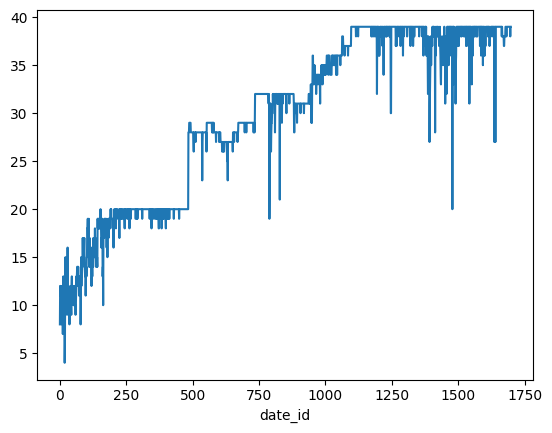

In [ ]:
df_research_train.groupby("date_id").symbol_id.nunique().plot()

In [ ]:
del df_research_train
gc.collect()
df_research_train = pd.read_feather(f"./research_data/research_data_train.feather.zstd")
df_research_train.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,target,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.775981,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,0.703665,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,2.109352,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,1.114137,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-3.572820,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-1.089123,-5.000000


# Preprocess


## Clip

In [ ]:
feature_clip_thresholds = {
    "feature_05":5,
    "feature_06":5,
    "feature_07":5,
    "feature_08":5,
    "feature_12":5,
    "feature_13":5,
    "feature_14":5,
    "feature_15":5,
    "feature_16":5,
    "feature_17":5,
    "feature_21":5, # special
    "feature_31":5,
    "feature_37":5,
    "feature_38":5,
    "feature_47":5,
    "feature_48":5,
    "feature_49":5,
    "feature_58":5,
    "feature_59":5,
    "feature_60":5,
    "feature_62":5,
    "feature_63":5,
    "feature_64":5,
    "feature_67":5,
    "feature_68":5,
    "feature_69":5,
    "feature_70":5,
    "feature_71":5,
    "feature_72":5,
    "feature_73":5,
    "feature_74":5,
    "feature_75":5,
    "feature_76":5,
    "feature_77":5,
    "feature_78":5,
}

In [ ]:
for f in feature_cols:
    # print(f)
    if f in feature_clip_thresholds:
        df_research_train[f] = np.clip(df_research_train[f], -feature_clip_thresholds[f], feature_clip_thresholds[f])

Plotting graph 79/79...

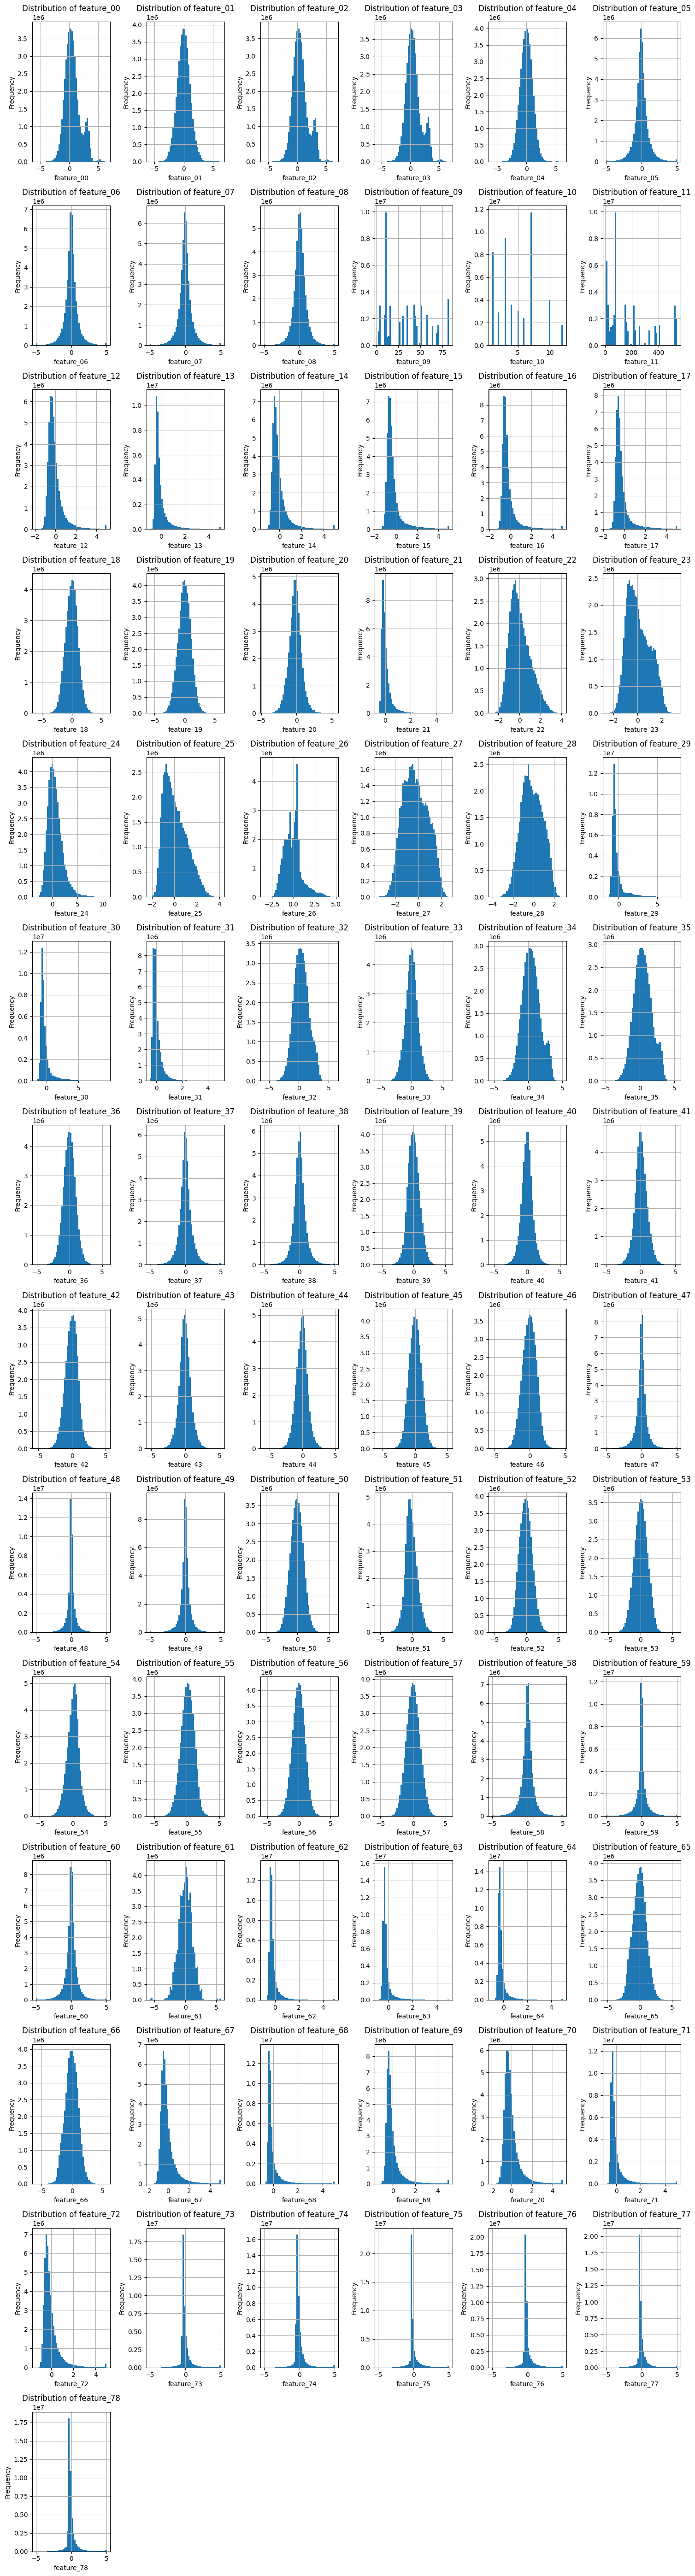

In [ ]:
# Determine the number of features and responders
n_cols = 6  # Number of columns in the grid
n_rows = (len(feature_cols) + n_cols - 1) // n_cols  # Calculate rows needed

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Visualize distributions of features and responders
for i, col in enumerate(feature_cols):
    # Overwrite previous message in the same line
    sys.stdout.write(f'\rPlotting graph {i + 1}/{len(feature_cols)}...')
    sys.stdout.flush()

    df_research_train[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

    time.sleep(0.5)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
feather.write_feather(df_research_train, "./research_data/research_data_train_clipped.feather.zstd", compression="zstd")

In [6]:
df_research_train = pd.read_feather("./research_data/research_data_train_clipped.feather.zstd")
gc.collect()

20

In [9]:
df_research_train.tail()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,target,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_7,responder_8
47127333,1698,967,34,3.242188,2.525391,-0.722168,2.544922,2.478516,0.417480,0.785645,...,0.016937,-0.132324,0.243530,0.166870,0.385010,-0.174316,-0.066040,-0.038757,-0.022430,-0.252441
47127334,1698,967,35,1.079102,1.857422,-0.790527,2.746094,2.339844,0.845215,0.651367,...,0.050873,-0.249634,0.850098,0.909180,1.015625,0.235962,0.122559,0.099548,-0.123596,-0.460693
47127335,1698,967,36,1.033203,2.515625,-0.672363,2.289062,2.521484,0.255127,0.919922,...,0.152344,-0.065369,0.395752,-0.292480,-3.216797,-0.535156,-0.178467,-1.808594,-0.000367,-0.125122
47127336,1698,967,37,1.243164,2.664062,-0.889160,2.312500,3.101562,0.324463,0.619141,...,-0.029480,-0.148682,1.925781,0.479492,3.621094,-0.107117,-0.063599,1.205078,-0.026581,-0.256348
47127337,1698,967,38,3.193359,2.728516,-0.745117,2.789062,2.343750,0.454834,0.862793,...,-0.247803,-0.138550,1.228516,0.512695,-0.050873,0.160889,0.080750,-0.078247,-0.038757,-0.211914


In [11]:
df_research_train.time_id.nunique()

968

In [14]:
df_research_train[df_research_train.symbol_id == 33]

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,target,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_7,responder_8
7,0,0,33,1.663086,NaN,NaN,NaN,NaN,NaN,1.182617,...,-0.171265,0.965332,0.209229,0.182739,0.010841,1.409180,0.002821,0.147583,-0.263672,0.280518
15,0,1,33,1.663086,NaN,NaN,NaN,NaN,NaN,0.852051,...,-0.216187,1.401367,0.214355,0.246826,-0.051147,1.204102,-0.079834,0.087952,-0.240356,0.181030
23,0,2,33,1.663086,NaN,NaN,NaN,NaN,NaN,1.125977,...,-0.259766,2.113281,0.182739,0.196899,-0.461182,1.717773,-0.068848,-0.007668,-0.385742,0.531250
31,0,3,33,1.663086,NaN,NaN,NaN,NaN,NaN,1.384766,...,-0.258301,1.133789,0.259521,0.219360,-0.240967,0.977051,-0.073975,-0.040833,-0.404785,0.295410
39,0,4,33,1.663086,NaN,NaN,NaN,NaN,NaN,1.067383,...,-0.227783,0.891602,-1.402344,-0.470703,-2.314453,-0.431152,-0.758789,-2.675781,-0.421143,-0.289062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47127176,1698,963,33,1.610352,2.296875,-0.696777,2.882812,2.947266,0.136230,0.400391,...,-0.166382,0.388184,0.330811,0.216064,-0.093689,0.708984,0.342773,0.473145,0.152954,0.872070
47127215,1698,964,33,1.610352,2.201172,-1.068359,2.857422,2.609375,0.446289,0.526855,...,-0.176392,0.168701,0.603027,0.293213,0.087036,0.812500,0.379395,0.365479,0.119263,0.450195
47127254,1698,965,33,1.610352,2.169922,-1.068359,2.595703,2.412109,0.628906,0.703125,...,-0.125732,-0.114807,1.309570,0.650879,0.438965,0.474854,0.340820,0.352295,-0.028656,-0.238281
47127293,1698,966,33,1.610352,2.363281,-0.480957,2.076172,3.232422,0.521973,0.833984,...,-0.147705,0.105103,1.208984,0.281250,0.052917,0.611328,0.247925,0.265869,0.086670,0.165283


In [ ]:
df_research_train[feature_cols] = df_research_train.groupby("symbol_id")[feature_cols].ffill()

In [ ]:
df_research_train = df_research_train[df_research_train.date_id > 500].reset_index(drop=True)

## Get cross validation datasets

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    ax.grid(True)
    return ax

In [ ]:
%%time
cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    # max_train_group_size=150,
    group_gap=5,
    # max_test_group_size=50
)
# fig, ax = plt.subplots()
# plot_cv_indices(
#     cv,
#     df_research_train[(df_research_train["date_id"] > 500)&(df_research_train["date_id"] < 600)][
#         "feature_01"
#     ].values,
#     df_research_train[(df_research_train["date_id"] > 500)&(df_research_train["date_id"] < 600)]['target'].values,
#     df_research_train[(df_research_train["date_id"] > 500)&(df_research_train["date_id"] < 600)]['date_id'].values,
#     ax,
#     5,
#     lw=20
# );

CPU times: user 22 µs, sys: 9 µs, total: 31 µs
Wall time: 35 µs


In [ ]:
df_research_train.isna().sum().sort_values(ascending=False)

,0
feature_26,638448
feature_21,638448
feature_31,638448
feature_27,638448
feature_42,721
...,...
feature_24,0
feature_23,0
feature_22,0
feature_20,0


In [ ]:
for i, (tr, tv) in enumerate(
    cv.split(df_research_train[df_research_train["date_id"] > 500][
        "feature_20"
    ].values,
    df_research_train[(df_research_train["date_id"] > 500)]['target'].values,
    df_research_train[(df_research_train["date_id"] > 500)]['date_id'].values)):

    print(i)
    print(len(tr))
    print(len(tv))
    X_train = df_research_train.iloc[tr]
    X_validation = df_research_train.iloc[tv]

    print("Writing training data...")
    feather.write_feather(
        X_train,
        f"./research_data/research_data_train_CV_{i}.feather.zstd",
        compression="zstd"
    )

    print("Writing validation data...")
    feather.write_feather(
        X_validation,
        f"./research_data/research_data_validation_CV_{i}.feather.zstd",
        compression="zstd"
    )



0
4760585
5957067
Writing training data...
Writing validation data...
1
10707009
6629827
Writing training data...
Writing validation data...
2
17298121
7435203
Writing training data...
Writing validation data...
3
24733329
7233859
Writing training data...
Writing validation data...
4
31969129
7397451
Writing training data...
Writing validation data...


# Model training

In [ ]:
# Custom Dataset for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: List[str], target_col: str, weight_col: str, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        # Convert to numpy first to check for NaN
        features = df[feature_cols].values
        targets = df[target_col].values
        weights = df[weight_col].values

        # Check for NaN
        if np.isnan(features).any():
            raise ValueError("NaN values found in features")
        if np.isnan(targets).any():
            raise ValueError("NaN values found in targets")
        if np.isnan(weights).any():
            raise ValueError("NaN values found in weights")

        self.features = torch.FloatTensor(features).to(device)
        self.target = torch.FloatTensor(targets).reshape(-1, 1).to(device)
        self.weights = torch.FloatTensor(weights).reshape(-1, 1).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx], self.weights[idx]

class VAEMLP(nn.Module):
    def __init__(self, num_columns: int, hidden_units: List[int], dropout_rates: List[float]):
        super(VAEMLP, self).__init__()

        # Common layers
        self.batch_norm_input = nn.LayerNorm(num_columns)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_columns, hidden_units[0]),
            nn.LayerNorm(hidden_units[0]),
            nn.SiLU()
        )

        # VAE latent space
        self.fc_mu = nn.Linear(hidden_units[0], hidden_units[0])
        self.fc_var = nn.Linear(hidden_units[0], hidden_units[0])

        # Decoder
        self.decoder_dropout = nn.Dropout(dropout_rates[0])
        self.decoder = nn.Linear(hidden_units[0], num_columns)

        # VAE branch
        self.vae_branch = nn.Sequential(
            nn.Linear(num_columns, hidden_units[1]),
            nn.LayerNorm(hidden_units[1]),
            nn.SiLU(),
            nn.Dropout(dropout_rates[1]),
            nn.Linear(hidden_units[1], 1)
        )

        # Main branch
        self.main_layers = nn.ModuleList()
        input_size = num_columns + hidden_units[0]

        self.initial_main = nn.Sequential(
            nn.LayerNorm(input_size),
            nn.Dropout(dropout_rates[2])
        )

        for i in range(2, len(hidden_units)):
            layer_block = nn.Sequential(
                nn.Linear(input_size, hidden_units[i]),
                nn.LayerNorm(hidden_units[i]),
                nn.SiLU(),
                nn.Dropout(dropout_rates[i + 1])
            )
            self.main_layers.append(layer_block)
            input_size = hidden_units[i]

        self.final_layer = nn.Linear(input_size, 1)

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Initial processing
        x0 = self.batch_norm_input(x)

        # Encoder path
        encoded = self.encoder(x0)

        # VAE latent space
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterize(mu, log_var)

        # Decoder path
        decoder_out = self.decoder(self.decoder_dropout(z))

        # VAE branch
        vae_out = self.vae_branch(decoder_out)

        # Main branch
        main = torch.cat([x0, z], dim=1)  # Using z instead of encoded
        main = self.initial_main(main)

        for layer in self.main_layers:
            main = layer(main)

        main_out = self.final_layer(main)

        return decoder_out, vae_out, main_out, mu, log_var

# Custom weighted MSE loss
class WeightedMSELoss(nn.Module):
    def forward(self, pred: torch.Tensor, target: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        return torch.mean(weights * (pred - target) ** 2) / torch.mean(weights * target**2)

class DecoderLoss(nn.Module):
    def forward(self, recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        MSE = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        total_loss = MSE + KLD
        return total_loss, MSE, KLD

class VAEMLPTrainer:
    def __init__(
        self,
        model: VAEMLP,
        optimizer: torch.optim.Optimizer,
        decoder_loss: DecoderLoss,
        weighted_loss: WeightedMSELoss,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.decoder_loss = decoder_loss
        self.weighted_loss = weighted_loss
        self.device = device
        print(f"Using device: {self.device}")

    def train_step(
        self,
        input_data: torch.Tensor,
        target_data: torch.Tensor,
        weights: torch.Tensor
    ) -> Dict[str, float]:
        self.model.train()
        self.optimizer.zero_grad(set_to_none=True)

        # Move data to device
        input_data = input_data.to(self.device)
        target_data = target_data.to(self.device)
        weights = weights.to(self.device)

        # Forward pass
        decoder_out, vae_out, main_out, mu, log_var = self.model(input_data)

        # Calculate losses
        decoder_loss, mse_loss, kld_loss = self.decoder_loss(decoder_out, input_data, mu, log_var)
        vae_loss = self.weighted_loss(vae_out, target_data, weights)
        main_loss = self.weighted_loss(main_out, target_data, weights)

        # Total loss
        # total_loss = decoder_loss + vae_loss + main_loss

        # Backward pass
        # total_loss.backward()

        # Backward passes
        decoder_loss.backward(retain_graph=True)
        vae_loss.backward(retain_graph=True)
        main_loss.backward()

        # Update weights
        self.optimizer.step()

        torch.cuda.empty_cache()

        return {
            'decoder_loss': decoder_loss.item(),
            'decoder_mse_loss': mse_loss.item(),
            'decoder_kld_loss': kld_loss.item(),
            'vae_loss': vae_loss.item(),
            'main_loss': main_loss.item()
        }

    @torch.no_grad()
    def validate_step(
        self,
        input_data: torch.Tensor,
        target_data: torch.Tensor,
        weights: torch.Tensor
    ) -> Dict[str, float]:
        self.model.eval()

        # Move data to device
        input_data = input_data.to(self.device)
        target_data = target_data.to(self.device)
        weights = weights.to(self.device)

        # Forward pass
        decoder_out, vae_out, main_out, mu, log_var = self.model(input_data)

        # Calculate losses
        decoder_loss, mse_loss, kld_loss = self.decoder_loss(decoder_out, input_data, mu, log_var)
        vae_loss = self.weighted_loss(vae_out, target_data, weights)
        main_loss = self.weighted_loss(main_out, target_data, weights)
        mae = torch.mean(torch.abs(main_out - target_data))

        return {
            'decoder_loss': decoder_loss.item(),
            'decoder_mse_loss': mse_loss.item(),
            'decoder_kld_loss': kld_loss.item(),
            'vae_loss': vae_loss.item(),
            'main_loss': main_loss.item(),
            'mae': mae.item()
        }

def create_vae_mlp(
    num_features: int,
    hidden_units: List[int],
    dropout_rates: List[float],
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    checkpoint=None,
) -> Tuple[VAEMLP, VAEMLPTrainer]:
    model = VAEMLP(num_features, hidden_units, dropout_rates)
    if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=weight_decay
    )

    decoder_loss = DecoderLoss()
    weighted_loss = WeightedMSELoss()

    trainer = VAEMLPTrainer(
        model=model,
        optimizer=optimizer,
        decoder_loss=decoder_loss,
        weighted_loss=weighted_loss,
        device=device
    )

    return model, trainer

In [ ]:
# for continuous training -  we want the prev best model to use
trained_fold_num = "4a"
checkpoint = torch.load(f"./best_model_fold_{trained_fold_num}.pt", map_location='cuda' if torch.cuda.is_available() else 'cpu')
print(checkpoint["avg_val"])
print("number of original features:", len(checkpoint["feature_cols"]))

<ipython-input-6-3a89789539eb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"./best_model_fold_{trained_fold_num}.pt", map_location='cuda' if to

{'decoder_loss': 44.21538387779641, 'decoder_mse_loss': 35.626303381624474, 'decoder_kld_loss': 8.58908055472163, 'vae_loss': 1.000196790141342, 'main_loss': 0.9960305266807564, 'mae': 0.5184166614065128}
number of original features: 76


In [ ]:
if "checkpoint" in locals():
    del checkpoint
trained_fold_num = -1

In [ ]:

# Usage example:

# Assuming your DataFrame has these columns:
# - feature columns (multiple)
# - 'target' column
# - 'weight' column

# Define your feature columns
# we already have feature_cols
def set_seed(seed: int = 42):
    """
    Set seeds for reproducibility
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.backends.cudnn.benchmark = True

########################
# SETUPS
bsz = 8192
hidden_units = [64, 256, 256, 256]
dropout_rates = [0.5, 0.2, 0.1, 0.5, 0.2] # vae decoder dropout, vae output dropout, mlp init dropout, mlp hidden dropout, mlp output dropout
feature_cols = [f"feature_{i:02d}" for i in range(79) if i not in [9, 10, 11]]
num_epochs = 10
early_stop_val_err = 1 - 0.01

# Create model and trainer

if "checkpoint" in locals():
    model, trainer = create_vae_mlp(
        num_features=len(checkpoint["feature_cols"]),
        hidden_units=checkpoint["hidden_units"],
        dropout_rates=checkpoint["dropout_rates"],
        checkpoint=checkpoint
    )
    model.eval()
    print("Model loaded from checkpoint")
else:
    model, trainer = create_vae_mlp(
        num_features=len(feature_cols),
        hidden_units=hidden_units,
        dropout_rates=dropout_rates
    )
##########################
for i in ["4a"]: #[trained_fold_num+1]:
    print(f"Fold {i}")
    print(f"Loading Training Data...")
    train = pd.read_feather(f"./research_data/research_data_train_CV_{i}.feather.zstd")
    train["target"] = np.clip(train["target"], -3, 3)
    print(f"Loading Validation Data...")
    if i[-1].isalpha():
        validation = pd.read_feather(f"./research_data/research_data_validation_CV_{int(i[:-1])}.feather.zstd")
    else:
        validation = pd.read_feather(f"./research_data/research_data_validation_CV_{i}.feather.zstd")
    train.fillna(0, inplace=True)
    validation.fillna(0, inplace=True)

    # Use it before training
    set_seed(42)

    # Create datasets
    print(f"Creating training dataset...")
    train_dataset = TimeSeriesDataset(
        df=train,
        feature_cols=feature_cols,
        target_col='target',
        weight_col='weight'
    )
    print(f"Creating validation dataset...")
    val_dataset = TimeSeriesDataset(
        df=validation,
        feature_cols=feature_cols,
        target_col='target',
        weight_col='weight'
    )

    # Create data loaders (no shuffling for time series)
    train_loader = DataLoader(train_dataset, batch_size=bsz, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=False)

    # Training loop

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Clear PyTorch cache
        torch.cuda.empty_cache()
        # Run Python garbage collector
        gc.collect()
        epoch_start_time = time.time()

        # Use accumulator objects instead of lists for metrics
        train_metrics = {
            'decoder_loss': 0.0,
            'decoder_mse_loss': 0.0,
            'decoder_kld_loss': 0.0,
            'vae_loss': 0.0,
            'main_loss': 0.0
        }
        val_metrics = {
            'decoder_loss': 0.0,
            'decoder_mse_loss': 0.0,
            'decoder_kld_loss': 0.0,
            'vae_loss': 0.0,
            'main_loss': 0.0,
            'mae': 0.0
        }

        n_train_batches = len(train_loader)
        n_val_batches = len(val_loader)

        # Training with progress bar
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("Training:")
        train_pbar = tqdm(
            train_loader,
            total=n_train_batches,
            desc=f"Training",
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'
        )

        # Training
        for batch_idx, (features, targets, weights) in enumerate(train_pbar):
            batch_metrics = trainer.train_step(features, targets, weights)
            # Update accumulated metrics
            for k, v in batch_metrics.items():
                train_metrics[k] += v

            # Update progress bar with running averages
            running_avg = {k: v / (batch_idx + 1) for k, v in train_metrics.items()}
            train_pbar.set_postfix({
                'decoder': f"{running_avg['decoder_loss']:.4f}",
                'decoder_mse': f"{running_avg['decoder_mse_loss']:.4f}",
                'decoder_kld': f"{running_avg['decoder_kld_loss']:.4f}",
                'vae': f"{running_avg['vae_loss']:.4f}",
                'main': f"{running_avg['main_loss']:.4f}"
            })

        train_pbar.close()
        print("Validation:")
        val_pbar = tqdm(
            val_loader,
            total=n_val_batches,
            desc=f"Validation",
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'
        )

        # Validation
        for batch_idx, (features, targets, weights) in enumerate(val_pbar):
            batch_metrics = trainer.validate_step(features, targets, weights)
            # Update accumulated metrics
            for k, v in batch_metrics.items():
                val_metrics[k] += v

            # Update progress bar with running averages
            running_avg = {k: v / (batch_idx + 1) for k, v in val_metrics.items()}
            val_pbar.set_postfix({
                'decoder': f"{running_avg['decoder_loss']:.4f}",
                'decoder_mse': f"{running_avg['decoder_mse_loss']:.4f}",
                'decoder_kld': f"{running_avg['decoder_kld_loss']:.4f}",
                'vae': f"{running_avg['vae_loss']:.4f}",
                'main': f"{running_avg['main_loss']:.4f}",
                'mae': f"{running_avg['mae']:.4f}"
            })

        val_pbar.close()

        # Calculate final averages
        avg_train = {k: v / n_train_batches for k, v in train_metrics.items()}
        avg_val = {k: v / n_val_batches for k, v in val_metrics.items()}

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Print metrics
        # Print epoch summary
        print(f"\nEpoch Summary:")
        print(f"Time: {epoch_time:.2f}s")
        print("Train:", ' '.join(f"{k}: {v:.4f}" for k, v in avg_train.items()))
        print("Val:", ' '.join(f"{k}: {v:.4f}" for k, v in avg_val.items()))

        # Save best model
        if avg_val['main_loss'] < best_val_loss:
            best_val_loss = avg_val['main_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'feature_cols': feature_cols,
                'hidden_units': hidden_units,
                'dropout_rates': dropout_rates,
                'avg_val': avg_val,
                'avg_train': avg_train
            }, f"best_model_fold_{i}.pt")

        # Early stop

        if avg_val['main_loss'] < early_stop_val_err:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            print(f"Validation main loss: {avg_val['main_loss']:.4f} < early_stop_val_err")
            break

    del train_loader, val_loader, train_dataset, val_dataset, train, validation, model, trainer
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    gc.collect()

Using device: cuda
Model loaded from checkpoint
Fold 4a
Loading Training Data...
Loading Validation Data...
Creating training dataset...
Creating validation dataset...

Epoch 1/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:11<00:00,  7.14it/s, decoder=50.8567, decoder_mse=41.5562, decoder_kld=9.3005, vae=0.9991, main=0.9904]


Validation:


Validation: 100%|████████████████████| 904/904 [01:54<00:00,  7.91it/s, decoder=44.5460, decoder_mse=36.0010, decoder_kld=8.5450, vae=1.0000, main=0.9963, mae=0.5186]



Epoch Summary:
Time: 425.79s
Train: decoder_loss: 50.8567 decoder_mse_loss: 41.5562 decoder_kld_loss: 9.3005 vae_loss: 0.9991 main_loss: 0.9904
Val: decoder_loss: 44.5460 decoder_mse_loss: 36.0010 decoder_kld_loss: 8.5450 vae_loss: 1.0000 main_loss: 0.9963 mae: 0.5186

Epoch 2/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:12<00:00,  7.13it/s, decoder=50.8044, decoder_mse=41.4723, decoder_kld=9.3321, vae=0.9991, main=0.9904]


Validation:


Validation: 100%|████████████████████| 904/904 [01:54<00:00,  7.89it/s, decoder=44.4135, decoder_mse=35.8818, decoder_kld=8.5316, vae=1.0000, main=0.9960, mae=0.5185]



Epoch Summary:
Time: 426.84s
Train: decoder_loss: 50.8044 decoder_mse_loss: 41.4723 decoder_kld_loss: 9.3321 vae_loss: 0.9991 main_loss: 0.9904
Val: decoder_loss: 44.4135 decoder_mse_loss: 35.8818 decoder_kld_loss: 8.5316 vae_loss: 1.0000 main_loss: 0.9960 mae: 0.5185

Epoch 3/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:12<00:00,  7.13it/s, decoder=50.8131, decoder_mse=41.4783, decoder_kld=9.3348, vae=0.9991, main=0.9904]


Validation:


Validation: 100%|████████████████████| 904/904 [01:54<00:00,  7.90it/s, decoder=44.3065, decoder_mse=35.7849, decoder_kld=8.5215, vae=1.0000, main=0.9963, mae=0.5186]



Epoch Summary:
Time: 426.51s
Train: decoder_loss: 50.8131 decoder_mse_loss: 41.4783 decoder_kld_loss: 9.3348 vae_loss: 0.9991 main_loss: 0.9904
Val: decoder_loss: 44.3065 decoder_mse_loss: 35.7849 decoder_kld_loss: 8.5215 vae_loss: 1.0000 main_loss: 0.9963 mae: 0.5186

Epoch 4/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:11<00:00,  7.14it/s, decoder=50.8132, decoder_mse=41.4763, decoder_kld=9.3369, vae=0.9992, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:54<00:00,  7.90it/s, decoder=44.2344, decoder_mse=35.7118, decoder_kld=8.5226, vae=0.9999, main=0.9960, mae=0.5184]



Epoch Summary:
Time: 426.13s
Train: decoder_loss: 50.8132 decoder_mse_loss: 41.4763 decoder_kld_loss: 9.3369 vae_loss: 0.9992 main_loss: 0.9905
Val: decoder_loss: 44.2344 decoder_mse_loss: 35.7118 decoder_kld_loss: 8.5226 vae_loss: 0.9999 main_loss: 0.9960 mae: 0.5184

Epoch 5/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:10<00:00,  7.15it/s, decoder=50.8000, decoder_mse=41.4625, decoder_kld=9.3375, vae=0.9991, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:53<00:00,  7.93it/s, decoder=44.1415, decoder_mse=35.6504, decoder_kld=8.4911, vae=1.0001, main=0.9964, mae=0.5187]



Epoch Summary:
Time: 424.97s
Train: decoder_loss: 50.8000 decoder_mse_loss: 41.4625 decoder_kld_loss: 9.3375 vae_loss: 0.9991 main_loss: 0.9905
Val: decoder_loss: 44.1415 decoder_mse_loss: 35.6504 decoder_kld_loss: 8.4911 vae_loss: 1.0001 main_loss: 0.9964 mae: 0.5187

Epoch 6/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:10<00:00,  7.16it/s, decoder=50.7946, decoder_mse=41.4602, decoder_kld=9.3344, vae=0.9992, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:53<00:00,  7.94it/s, decoder=44.0743, decoder_mse=35.5769, decoder_kld=8.4974, vae=1.0001, main=0.9960, mae=0.5185]



Epoch Summary:
Time: 424.67s
Train: decoder_loss: 50.7946 decoder_mse_loss: 41.4602 decoder_kld_loss: 9.3344 vae_loss: 0.9992 main_loss: 0.9905
Val: decoder_loss: 44.0743 decoder_mse_loss: 35.5769 decoder_kld_loss: 8.4974 vae_loss: 1.0001 main_loss: 0.9960 mae: 0.5185

Epoch 7/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:09<00:00,  7.18it/s, decoder=50.7828, decoder_mse=41.4419, decoder_kld=9.3410, vae=0.9991, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:53<00:00,  7.96it/s, decoder=44.0026, decoder_mse=35.4937, decoder_kld=8.5090, vae=1.0002, main=0.9962, mae=0.5185]



Epoch Summary:
Time: 423.41s
Train: decoder_loss: 50.7828 decoder_mse_loss: 41.4419 decoder_kld_loss: 9.3410 vae_loss: 0.9991 main_loss: 0.9905
Val: decoder_loss: 44.0026 decoder_mse_loss: 35.4937 decoder_kld_loss: 8.5090 vae_loss: 1.0002 main_loss: 0.9962 mae: 0.5185

Epoch 8/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:09<00:00,  7.19it/s, decoder=50.7911, decoder_mse=41.4571, decoder_kld=9.3339, vae=0.9991, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:53<00:00,  8.00it/s, decoder=44.0316, decoder_mse=35.5615, decoder_kld=8.4701, vae=1.0002, main=0.9962, mae=0.5185]



Epoch Summary:
Time: 422.61s
Train: decoder_loss: 50.7911 decoder_mse_loss: 41.4571 decoder_kld_loss: 9.3339 vae_loss: 0.9991 main_loss: 0.9905
Val: decoder_loss: 44.0316 decoder_mse_loss: 35.5615 decoder_kld_loss: 8.4701 vae_loss: 1.0002 main_loss: 0.9962 mae: 0.5185

Epoch 9/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:07<00:00,  7.23it/s, decoder=50.8208, decoder_mse=41.4965, decoder_kld=9.3243, vae=0.9991, main=0.9904]


Validation:


Validation: 100%|████████████████████| 904/904 [01:52<00:00,  8.01it/s, decoder=44.0765, decoder_mse=35.6262, decoder_kld=8.4503, vae=1.0003, main=0.9961, mae=0.5186]



Epoch Summary:
Time: 420.65s
Train: decoder_loss: 50.8208 decoder_mse_loss: 41.4965 decoder_kld_loss: 9.3243 vae_loss: 0.9991 main_loss: 0.9904
Val: decoder_loss: 44.0765 decoder_mse_loss: 35.6262 decoder_kld_loss: 8.4503 vae_loss: 1.0003 main_loss: 0.9961 mae: 0.5186

Epoch 10/10
Training:


Training: 100%|████████████████████| 2225/2225 [05:07<00:00,  7.23it/s, decoder=50.8244, decoder_mse=41.4993, decoder_kld=9.3251, vae=0.9991, main=0.9905]


Validation:


Validation: 100%|████████████████████| 904/904 [01:52<00:00,  8.02it/s, decoder=44.1724, decoder_mse=35.7086, decoder_kld=8.4638, vae=1.0001, main=0.9960, mae=0.5184]



Epoch Summary:
Time: 420.57s
Train: decoder_loss: 50.8244 decoder_mse_loss: 41.4993 decoder_kld_loss: 9.3251 vae_loss: 0.9991 main_loss: 0.9905
Val: decoder_loss: 44.1724 decoder_mse_loss: 35.7086 decoder_kld_loss: 8.4638 vae_loss: 1.0001 main_loss: 0.9960 mae: 0.5184


```
Using device: cuda
Fold 0
Loading Training Data...
Loading Validation Data...
Creating training dataset...
Creating validation dataset...

Epoch 1/15
Training:
Training: 100%|████████████████████| 582/582 [01:23<00:00,  6.99it/s, decoder=63.5022, decoder_mse=54.4204, decoder_kld=9.0817, vae=1.0078, main=1.0020]
Validation:
Validation: 100%|████████████████████| 728/728 [01:35<00:00,  7.66it/s, decoder=55.0941, decoder_mse=46.1195, decoder_kld=8.9746, vae=1.0012, main=0.9896, mae=0.5932]
Epoch Summary:
Time: 178.39s
Train: decoder_loss: 63.5022 decoder_mse_loss: 54.4204 decoder_kld_loss: 9.0817 vae_loss: 1.0078 main_loss: 1.0020
Val: decoder_loss: 55.0941 decoder_mse_loss: 46.1195 decoder_kld_loss: 8.9746 vae_loss: 1.0012 main_loss: 0.9896 mae: 0.5932

Early stopping triggered at epoch 1
Validation main loss: 0.9896 < early_stop_val_err

=============================

Using device: cuda
Model loaded from checkpoint
Fold 2
Loading Training Data...
Loading Validation Data...
Creating training dataset...
Creating validation dataset...

Epoch 10/10
Training:
Training: 100%|████████████████████| 2112/2112 [05:05<00:00,  6.91it/s, decoder=51.9239, decoder_mse=42.9212, decoder_kld=9.0028, vae=0.9990, main=0.9887]
Validation:
Validation: 100%|████████████████████| 908/908 [01:57<00:00,  7.71it/s, decoder=52.7983, decoder_mse=45.3114, decoder_kld=7.4869, vae=0.9999, main=0.9919, mae=0.5698]

Epoch Summary:
Time: 423.70s
Train: decoder_loss: 51.9239 decoder_mse_loss: 42.9212 decoder_kld_loss: 9.0028 vae_loss: 0.9990 main_loss: 0.9887
Val: decoder_loss: 52.7983 decoder_mse_loss: 45.3114 decoder_kld_loss: 7.4869 vae_loss: 0.9999 main_loss: 0.9919 mae: 0.5698

==============================
Using device: cuda
Model loaded from checkpoint
Fold 3
Loading Training Data...
Loading Validation Data...
Creating training dataset...
Creating validation dataset...

Epoch 10/10
Training:
Training: 100%|████████████████████| 3020/3020 [07:18<00:00,  6.89it/s, decoder=52.0302, decoder_mse=42.8976, decoder_kld=9.1325, vae=0.9990, main=0.9893]
Validation:
Validation: 100%|████████████████████| 884/884 [01:56<00:00,  7.61it/s, decoder=54.6570, decoder_mse=46.6357, decoder_kld=8.0213, vae=0.9994, main=0.9924, mae=0.5720]

Epoch Summary:
Time: 554.27s
Train: decoder_loss: 52.0302 decoder_mse_loss: 42.8976 decoder_kld_loss: 9.1325 vae_loss: 0.9990 main_loss: 0.9893
Val: decoder_loss: 54.6570 decoder_mse_loss: 46.6357 decoder_kld_loss: 8.0213 vae_loss: 0.9994 main_loss: 0.9924 mae: 0.5720

```

$$
R^2 = 1 - \frac{\sum w_i (y_i - \hat{y}_i)^2}{\sum w_i y_i^2}
$$

# Estimate error in validation sets

In [ ]:
if "validation" in locals():
    del validation
    gc.collect()
validation = pd.read_feather(f"./research_data/research_data_validation_CV_4.feather.zstd")

In [ ]:
checkpoint_3 = torch.load(f"./best_model_fold_3.pt", map_location='cuda' if torch.cuda.is_available() else 'cpu')
print(checkpoint_3["avg_val"])

checkpoint_4a = torch.load(f"./best_model_fold_4a.pt", map_location='cuda' if torch.cuda.is_available() else 'cpu')
print(checkpoint_4a["avg_val"])

<ipython-input-7-300a4011a62a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_3 = torch.load(f"./best_model_fold_3.pt", map_location='cuda' if torch.cuda.is_ava

{'decoder_loss': 54.68483757433309, 'decoder_mse_loss': 46.670417498679186, 'decoder_kld_loss': 8.014420116648955, 'vae_loss': 0.999331376940956, 'main_loss': 0.9924252122236054, 'mae': 0.5721250017809921}


<ipython-input-7-300a4011a62a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_4a = torch.load(f"./best_model_fold_4a.pt", map_location='cuda' if torch.cuda.is_a

{'decoder_loss': 44.23442542236463, 'decoder_mse_loss': 35.711804402613005, 'decoder_kld_loss': 8.522620971751424, 'vae_loss': 0.9998722725209936, 'main_loss': 0.9959605566959465, 'mae': 0.5183580421834393}


In [ ]:
model_3, trainer_3 = create_vae_mlp(
    num_features=len(checkpoint_3["feature_cols"]),
    hidden_units=checkpoint_3["hidden_units"],
    dropout_rates=checkpoint_3["dropout_rates"],
    checkpoint=checkpoint_3
)

Using device: cpu


In [ ]:
model_4a, trainer_4a = create_vae_mlp(
    num_features=len(checkpoint_4a["feature_cols"]),
    hidden_units=checkpoint_4a["hidden_units"],
    dropout_rates=checkpoint_4a["dropout_rates"],
    checkpoint=checkpoint_4a
)

Using device: cpu


In [ ]:
def predict_in_batches(model, df: pd.DataFrame, feature_cols: list, batch_size: int = 500000,
                      device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Make predictions in batches to handle large datasets
    """
    model.eval()
    predictions = []

    # Get total number of samples
    n_samples = len(df)

    # Process in batches
    with torch.no_grad():
        for start_idx in range(0, n_samples, batch_size):
            print(start_idx, end=" ")
            end_idx = min(start_idx + batch_size, n_samples)
            batch_df = df.iloc[start_idx:end_idx]

            # Convert batch to tensor
            batch_features = torch.FloatTensor(batch_df[feature_cols].values).to(device)

            # Get predictions
            _, _, batch_preds, _, _ = model(batch_features)

            # Move predictions to CPU and convert to numpy
            predictions.append(batch_preds.cpu().numpy())

            # Optional: free memory
            del batch_features
            torch.cuda.empty_cache()
            gc.collect()

    # Concatenate all batch predictions
    result_df = pd.DataFrame({"row_id": df.index, "weight":df["weight"], "target":df["target"], "prediction":np.concatenate(predictions).flatten()})
    return result_df

def evaluate_predictions(df: pd.DataFrame,
                        pred_col: str = 'prediction',
                        target_col: str = 'target',
                        weight_col: str = 'weight',
                        batch_size: int = 500000):
    """
    Evaluate predictions using weighted metrics

    Args:
        df: DataFrame with predictions, targets, and weights
        pred_col: Name of predictions column
        target_col: Name of target column
        weight_col: Name of weight column
        batch_size: Batch size for memory efficiency
    """
    weighted_loss = WeightedMSELoss()
    n_samples = len(df)
    n_batches = (n_samples + batch_size - 1) // batch_size

    metrics = {
        'weighted_mse': 0.0,
        'mae': 0.0,
        'mse': 0.0
    }

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    pbar = tqdm(
        range(0, n_samples, batch_size),
        total=n_batches,
        desc="Evaluating",
        bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'
    )

    for batch_start in pbar:
        batch_end = min(batch_start + batch_size, n_samples)
        batch = df.iloc[batch_start:batch_end]

        # Convert to tensors
        preds = torch.FloatTensor(batch[pred_col].values).reshape(-1, 1).to(device)
        targets = torch.FloatTensor(batch[target_col].values).reshape(-1, 1).to(device)
        weights = torch.FloatTensor(batch[weight_col].values).reshape(-1, 1).to(device)

        # Calculate metrics
        batch_metrics = {
            'weighted_mse': weighted_loss(preds, targets, weights).item(),
            'mae': torch.mean(torch.abs(preds - targets)).item(),
            'mse': torch.mean((preds - targets) ** 2).item()
        }

        # Update metrics
        for k, v in batch_metrics.items():
            metrics[k] += v

        # Update progress bar
        running_avg = {k: v / ((batch_start // batch_size) + 1) for k, v in metrics.items()}
        pbar.set_postfix({
            'wmse': f"{running_avg['weighted_mse']:.4f}",
            'mae': f"{running_avg['mae']:.4f}",
            'mse': f"{running_avg['mse']:.4f}"
        })

    pbar.close()

    # Calculate final averages
    final_metrics = {k: v / n_batches for k, v in metrics.items()}

    print("\nFinal Metrics:")
    for k, v in final_metrics.items():
        print(f"{k}: {v:.4f}")

    return final_metrics

In [ ]:
predictions_3 = predict_in_batches(model_3, validation, checkpoint_3["feature_cols"])

0 500000 1000000 1500000 2000000 2500000 3000000 3500000 4000000 4500000 5000000 5500000 6000000 6500000 7000000 

In [ ]:
metrics_3 = evaluate_predictions(predictions_3)

Evaluating: 100%|████████████████████| 15/15 [00:00<00:00, 218.65it/s, wmse=0.9971, mae=0.5179, mse=0.6267]


Final Metrics:
weighted_mse: 0.9971
mae: 0.5179
mse: 0.6267


In [ ]:
predictions_4a = predict_in_batches(model_4a, validation, checkpoint_4a["feature_cols"])
metrics_4a = evaluate_predictions(predictions_4a)

0 500000 1000000 1500000 2000000 2500000 3000000 3500000 4000000 4500000 5000000 5500000 6000000 6500000 7000000 

Evaluating: 100%|████████████████████| 15/15 [00:00<00:00, 295.87it/s, wmse=0.9959, mae=0.5182, mse=0.6259]


Final Metrics:
weighted_mse: 0.9959
mae: 0.5182
mse: 0.6259


# Test on test set